# Practical example: _Support Vector Machine (SVM)_.

## Data set: Malicious URL detection

### Description
The Web has long become a major platform for online criminal activities, with URLs being the primary vehicle for these illicit operations. To counter this issue, the security community has focused on developing techniques, primarily involving the blacklisting of malicious URLs.

While this approach has been successful in protecting users from known malicious domains, it only addresses part of the problem. Newly created malicious URLs frequently emerge across the web, often gaining an advantage in this race. Additionally, even Alexa-ranked trusted websites can contain compromised fraudulent URLs known as defacement URLs.

We focus on five main types of URLs:

**Benign URLs**: Over 35,300 benign URLs were collected from Alexa's top websites. The domains were passed through a Heritrix web crawler to extract the URLs. Initially, about half a million unique URLs were crawled, then duplicates and domain-only URLs were removed. Finally, the extracted URLs were checked through VirusTotal to filter the benign ones.

**Spam URLs**: Approximately 12,000 spam URLs were collected from the publicly available WEBSPAM-UK2007 dataset.

**Phishing URLs**: Around 10,000 phishing URLs were taken from OpenPhish, a repository of active phishing sites.

**Malware URLs**: More than 11,500 URLs related to malware websites were obtained from DNS-BH, a project that maintains a list of malware sites.

**Defacement URLs**: Over 45,450 URLs belong to the Defacement URL category. These URLs come from Alexa-ranked trusted websites hosting fraudulent or hidden URLs containing malicious web pages.

### Download data files
[Download Dataset](https://www.unb.ca/cic/datasets/url-2016.html)

### Additional references on the dataset
_Mohammad Saiful Islam Mamun, Mohammad Ahmad Rathore, Arash Habibi Lashkari, Natalia Stakhanova and Ali A. Ghorbani, "Detecting Malicious URLs Using Lexical Analysis", Network and System Security, Springer International Publishing, P467--482, 2016._


## Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

Mounted at /content/drive


## Auxiliary functions

In [3]:
# Construction of a function that performs full partitioning
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [4]:
# Graphical representation of the decision limit
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

## 1. Reading the dataset

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Aprendizaje_automatico/Phishing.csv")



## 2. Preview of information

In [6]:
df.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.0,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.5,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.0,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign
5,0,2,10,5.5,9,4.100000,2,15,11,0,...,-1,-1,-1,0.732981,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
6,0,2,12,4.5,6,5.333334,2,24,9,0,...,0,0,-1,0.692383,0.939794,0.910795,0.673973,0.00000,-1.000000,benign
7,0,2,11,3.5,4,3.909091,2,15,6,0,...,0,0,-1,0.707365,0.916667,0.916667,0.690332,0.00000,-1.000000,benign
8,0,2,9,2.5,3,4.555555,2,6,3,0,...,1,0,-1,0.742606,1.000000,0.785719,0.808833,1.00000,-1.000000,benign
9,0,2,13,4.5,6,5.307692,2,16,9,1,...,-1,-1,-1,0.734633,0.939794,-1.000000,-1.000000,-1.00000,-1.000000,benign


In [7]:
df.describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
count,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15096.000000,15367.000000,15367.000000,15367.000000,15367.000000,...,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,13541.000000,15177.000000,15364.000000,15364.000000
mean,3.446021,2.543698,8.477061,5.851956,10.027461,5.289936,2.543698,12.659986,8.398516,1.910913,...,2.120843,1.124618,0.500813,-0.158782,0.721684,0.854232,0.634859,0.682896,0.313617,-0.723793
std,14.151453,0.944938,4.660250,2.064581,5.281090,3.535097,0.944938,8.562206,6.329007,4.657731,...,2.777307,2.570246,2.261013,2.535939,0.049246,0.072641,0.510992,0.502288,0.576910,0.649785
min,0.000000,2.000000,0.000000,1.500000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.419560,0.561913,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,2.000000,5.000000,4.500000,7.000000,3.800000,2.000000,6.000000,4.000000,0.000000,...,1.000000,0.000000,0.000000,-1.000000,0.687215,0.798231,0.709532,0.707165,0.000000,-1.000000
50%,0.000000,2.000000,8.000000,5.500000,9.000000,4.500000,2.000000,11.000000,7.000000,0.000000,...,2.000000,0.000000,0.000000,-1.000000,0.723217,0.859793,0.785949,0.814038,0.000000,-1.000000
75%,0.000000,3.000000,11.000000,6.666666,12.000000,5.571429,3.000000,17.000000,11.000000,1.000000,...,3.000000,1.000000,0.000000,-1.000000,0.757949,0.916667,0.859582,0.916667,1.000000,-1.000000
max,173.000000,19.000000,68.000000,29.500000,63.000000,105.000000,19.000000,94.000000,62.000000,58.000000,...,24.000000,31.000000,30.000000,29.000000,0.869701,1.000000,0.962479,1.000000,1.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15367 entries, 0 to 15366
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      15367 non-null  int64  
 1   domain_token_count               15367 non-null  int64  
 2   path_token_count                 15367 non-null  int64  
 3   avgdomaintokenlen                15367 non-null  float64
 4   longdomaintokenlen               15367 non-null  int64  
 5   avgpathtokenlen                  15096 non-null  float64
 6   tld                              15367 non-null  int64  
 7   charcompvowels                   15367 non-null  int64  
 8   charcompace                      15367 non-null  int64  
 9   ldl_url                          15367 non-null  int64  
 10  ldl_domain                       15367 non-null  int64  
 11  ldl_path                         15367 non-null  int64  
 12  ldl_filename      

In [9]:
df["URL_Type_obf_Type"].value_counts()

,count
URL_Type_obf_Type,
benign,7781
phishing,7586


In [10]:
# Checking for null values
is_null = df.isna().any()
is_null[is_null]

,0
avgpathtokenlen,True
NumberRate_DirectoryName,True
NumberRate_FileName,True
NumberRate_Extension,True
NumberRate_AfterPath,True
Entropy_DirectoryName,True
Entropy_Filename,True
Entropy_Extension,True
Entropy_Afterpath,True


In [11]:
# Verification of the existence of infinite values
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

,0
argPathRatio,True


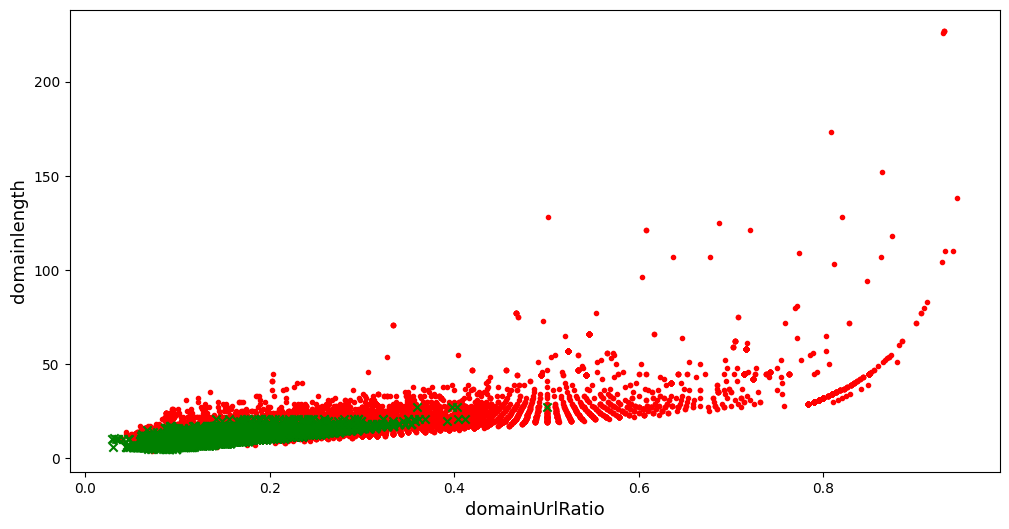

In [12]:
# Graphical representation of two characteristics
plt.figure(figsize=(12, 6))
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "phishing"], df["domainlength"][df['URL_Type_obf_Type'] == "phishing"], c="r", marker=".")
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "benign"], df["domainlength"][df['URL_Type_obf_Type'] == "benign"], c="g", marker="x")
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainlength", fontsize=13)
plt.show()


The **DomainUrlRatio** refers to a metric used in phishing datasets to describe the relationship between the length of the domain and the total length of the URL. It is a feature that can help detect suspicious URLs, particularly in phishing detection.

### Definition:
The **DomainUrlRatio** is calculated as the ratio of the domain length to the total URL length. Mathematically, it can be expressed as:

$$
\text{DomainUrlRatio} = \frac{\text{domain length}}{\text{total URL length}}
$$

- **Domain length**: Refers to the primary domain portion of the URL, which usually includes the domain name and extension (e.g., in "www.example.com", the domain is "example.com").
- **Total URL length**: Includes all components of the URL, such as the protocol, subdomains, domain, paths, and parameters (e.g., "https://www.example.com/path?query=1").

### Interpretation:
- **Values close to 1**: Indicate that the majority of the URL consists of the main domain. This is typical of simpler, more direct URLs.
- **Smaller values**: Indicate that the URL is more complex, with a greater number of subdomains, paths, or parameters, which could be an indicator of a suspicious or malicious URL.

### Example:
1. **Legitimate URL**: `https://www.google.com/search?q=openai`
   - Domain length: 10 characters (`google.com`).
   - Total URL length: 35 characters.
   - **DomainUrlRatio**:
   $$
   \frac{10}{35} = 0.285
   $$

2. **Phishing URL**: `https://account-login-security.example-fake-login.com/signin?auth=false`
   - Domain length: 27 characters (`example-fake-login.com`).
   - Total URL length: 77 characters.
   - **DomainUrlRatio**:
   $$
   \frac{27}{77} = 0.35
   $$

Although both examples have low **DomainUrlRatio**, phishing URLs often include additional parameters, long paths, or misleading subdomains, which can reduce this ratio.

### Usage in Phishing Detection:
Phishing attackers often create long URLs with extra subdomains or misleading parameters to confuse users. A low **DomainUrlRatio** can be a signal that the URL has been manipulated to appear legitimate when it actually redirects to a malicious site.


The **DomainLength** refers to the total number of characters in the domain portion of a URL. This metric is often used in phishing datasets because malicious websites frequently use unusually long or complex domain names in an attempt to mislead users into thinking the site is legitimate.

### Definition:
The **DomainLength** is simply the number of characters in the domain, including the domain name and its extension (e.g., `.com`, `.net`, etc.).

### Interpretation:
- **Short domain length**: Generally, trusted or popular websites tend to have shorter domain names (e.g., `google.com` or `amazon.com`).
- **Long domain length**: Phishing websites or suspicious URLs often have longer domain names, including multiple subdomains or strings that mimic legitimate names to trick users (e.g., `secure-login-example.com`).

### Example:
1. **Legitimate URL**: `https://www.google.com`
   - Domain: `google.com`
   - **DomainLength**: 10 characters

2. **Phishing URL**: `https://secure-login-example-fake.com`
   - Domain: `example-fake.com`
   - **DomainLength**: 16 characters

In general, while domain length alone is not a definitive indicator of phishing, it can be one of the features used in combination with others (such as `DomainUrlRatio`, path length, or the presence of special characters) to detect potentially malicious URLs.

### Usage in Phishing Detection:
Long and complex domain names, especially when they include misleading keywords (e.g., "secure", "login", or "account"), are often an indicator of phishing attempts. Monitoring domain lengths as part of a broader URL analysis can help identify suspicious sites.


## 3. Division of the data set

In [13]:
# Division of the data set
train_set, val_set, test_set = train_val_test_split(df)

In [14]:
X_train = train_set.drop("URL_Type_obf_Type", axis=1)
y_train = train_set["URL_Type_obf_Type"].copy()

X_val = val_set.drop("URL_Type_obf_Type", axis=1)
y_val = val_set["URL_Type_obf_Type"].copy()

X_test = test_set.drop("URL_Type_obf_Type", axis=1)
y_test = test_set["URL_Type_obf_Type"].copy()

## 4. Preparation of the dataset

In [15]:
# We remove the attribute that has infinite values
X_train = X_train.drop("argPathRatio", axis=1)
X_val = X_val.drop("argPathRatio", axis=1)
X_test = X_test.drop("argPathRatio", axis=1)

In [16]:
# We fill in the null values with the median
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [17]:
# We fill in the null values
X_train_prep = imputer.fit_transform(X_train)
X_val_prep = imputer.fit_transform(X_val)
X_test_prep = imputer.fit_transform(X_test)

In [18]:
# Transform the result to a Pandas DataFrame
X_train_prep = pd.DataFrame(X_train_prep, columns=X_train.columns, index=y_train.index)
X_val_prep = pd.DataFrame(X_val_prep, columns=X_val.columns, index=y_val.index)
X_test_prep = pd.DataFrame(X_test_prep, columns=X_test.columns, index=y_test.index)

In [19]:
X_train_prep.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
2134,0.0,2.0,6.0,2.000000,2.0,8.666667,2.0,17.0,10.0,0.0,...,2.0,0.0,0.0,-1.0,0.681183,0.827729,0.702637,0.849605,0.000000,-1.000000
9178,0.0,4.0,18.0,3.250000,5.0,1.000000,4.0,18.0,13.0,2.0,...,12.0,3.0,0.0,4.0,0.695232,0.820160,0.682849,0.875578,0.000000,0.778747
13622,0.0,3.0,3.0,6.666666,14.0,4.000000,3.0,1.0,1.0,1.0,...,1.0,0.0,0.0,-1.0,0.836006,0.869991,0.879588,1.000000,0.000000,-1.000000
15182,0.0,3.0,5.0,3.333333,4.0,3.000000,3.0,5.0,2.0,0.0,...,2.0,1.0,0.0,-1.0,0.731804,0.796490,0.796658,1.000000,1.000000,-1.000000
8013,74.0,2.0,13.0,9.500000,17.0,7.875000,2.0,21.0,29.0,26.0,...,4.0,5.0,4.0,3.0,0.653371,0.820569,0.758055,0.714969,0.712215,0.708031
12408,0.0,3.0,4.0,8.333333,19.0,3.750000,3.0,5.0,1.0,0.0,...,2.0,0.0,0.0,-1.0,0.726479,0.789538,0.800705,1.000000,0.000000,-1.000000
509,20.0,2.0,13.0,4.500000,6.0,3.000000,2.0,24.0,17.0,0.0,...,1.0,14.0,13.0,12.0,0.678515,0.796658,0.871049,0.695112,0.701662,0.698106
10714,0.0,3.0,8.0,6.666666,14.0,4.250000,3.0,11.0,5.0,0.0,...,4.0,0.0,0.0,-1.0,0.745348,0.869991,0.788921,1.000000,0.000000,-1.000000
3986,0.0,2.0,6.0,6.500000,10.0,4.500000,2.0,7.0,7.0,0.0,...,2.0,0.0,0.0,-1.0,0.760843,0.798231,0.822491,0.796670,0.000000,-1.000000
748,0.0,2.0,8.0,4.000000,5.0,5.750000,2.0,14.0,14.0,1.0,...,2.0,0.0,0.0,-1.0,0.709062,0.929897,0.884735,0.674994,0.000000,-1.000000


In [21]:
# We check for null values in the training data set.
is_null = X_train_prep.isna().any()
is_null[is_null]

,0


## 5. SMV: Kernel lineal

### 5.1 Reduced data set

**Training the algorithm with a reduced dataset**

In [22]:
# We reduce the dataset to represent it graphically.
X_train_reduced = X_train_prep[["domainUrlRatio", "domainlength"]].copy()
X_val_reduced = X_val_prep[["domainUrlRatio", "domainlength"]].copy()

In [23]:
X_train_reduced

,domainUrlRatio,domainlength
2134,0.072464,5.0
9178,0.166667,16.0
13622,0.511628,22.0
15182,0.315789,12.0
8013,0.107527,20.0
...,...,...
5191,0.116667,14.0
13418,0.477273,21.0
5390,0.157895,9.0
860,0.072917,7.0


The code `svm_clf = SVC(kernel="linear", C=50)` creates an SVM (Support Vector Machine) classifier using the `SVC` class from the **scikit-learn** library in Python. Here is a detailed explanation of each component:

### 1. **`SVC`**:
   - `SVC` stands for **Support Vector Classification**, which is an implementation of a classifier based on **Support Vector Machines (SVM)** in **scikit-learn**.
   - SVM is a supervised machine learning algorithm used for classification and regression. Its goal is to find a hyperplane that best separates the data into different classes, maximizing the margin between the closest data points (support vectors) of different classes.

### 2. **`kernel="linear"`**:
   - The `kernel` parameter specifies the type of kernel function that will be used to transform the data. In this case, `"linear"` indicates that a **linear kernel** will be used.
   - A linear kernel means that the SVM algorithm will look for a linear hyperplane to separate the data. That is, the classifier will try to find a line (in the case of 2D data) or a plane (in 3D) that divides the classes.
   - If the data is linearly separable, this is a good kernel to use. Other kernel types, such as polynomial or RBF (Radial Basis Function), are used when the data is not linearly separable.

### 3. **`C=50`**:
   - The `C` parameter is a **regularization** hyperparameter in SVM.
   - It controls the **trade-off** between the margin of the classifier and the classification error. A higher value of `C` gives less weight to classification errors, so the model will try harder to correctly classify each training example.
     - **If `C` is large (like in this case, `C=50`)**: The SVM will aim to fit the training data more closely, allowing fewer classification errors, but it may risk overfitting.
     - **If `C` is small**: The model will have a wider margin, allowing more classification errors on the training data, but improving generalization and avoiding overfitting.
   



In [24]:
from sklearn.svm import SVC

# SVM Large Margin Classification
svm_clf = SVC(kernel="linear", C=50)
svm_clf.fit(X_train_reduced, y_train)

SVC(C=50, kernel='linear')

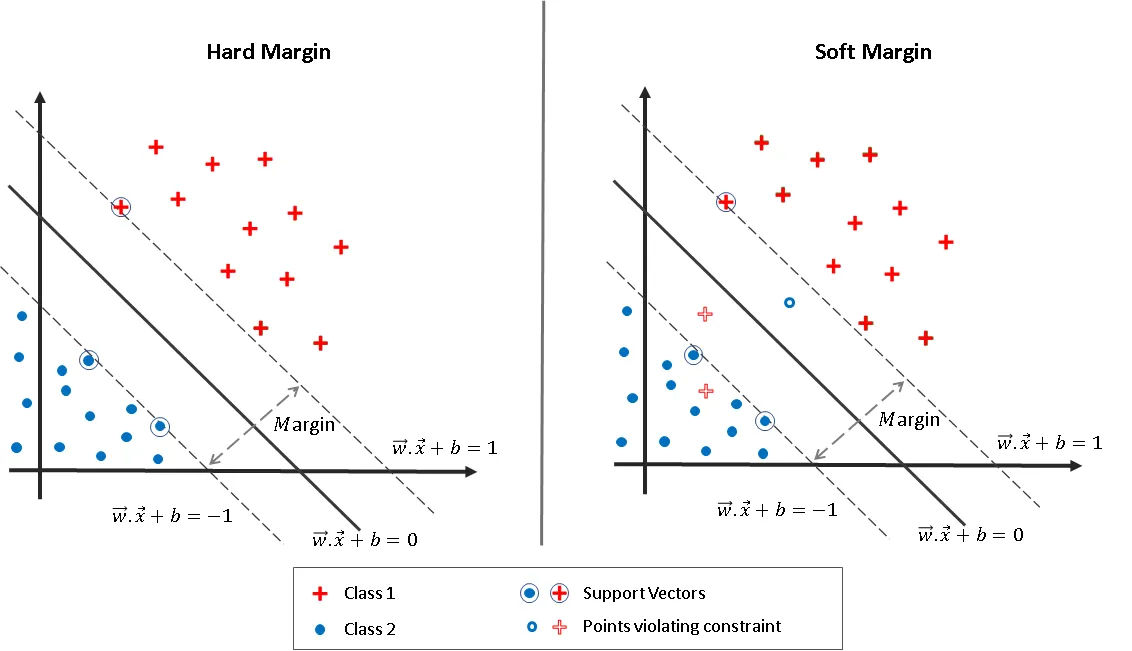

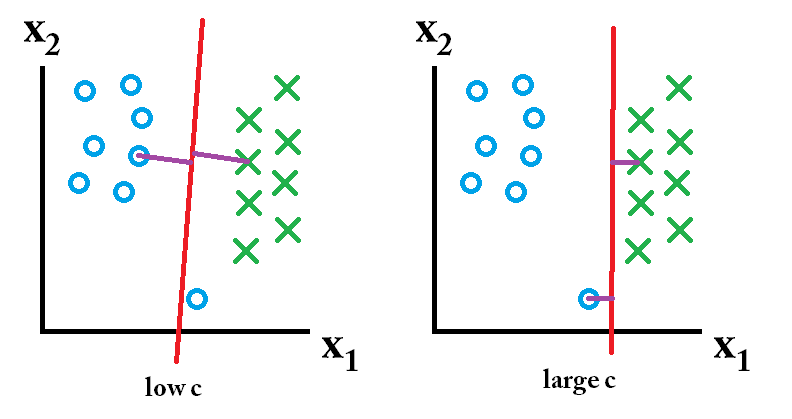

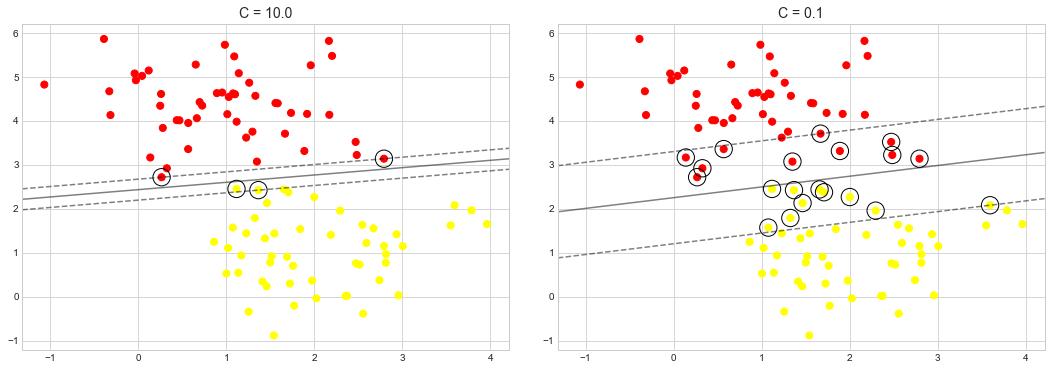

**Representation of the decision boundary**

In [25]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

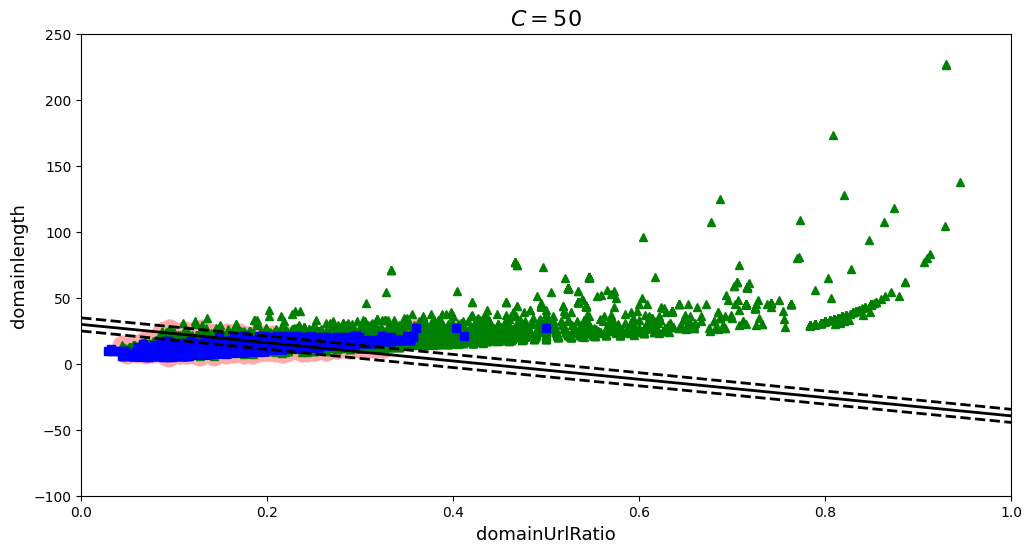

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(X_train_reduced.values[:, 0][y_train=="phishing"], X_train_reduced.values[:, 1][y_train=="phishing"], "g^")
plt.plot(X_train_reduced.values[:, 0][y_train=="benign"], X_train_reduced.values[:, 1][y_train=="benign"], "bs")
plot_svc_decision_boundary(svm_clf, 0, 1)
plt.title("$C = {}$".format(svm_clf.C), fontsize=16)
plt.axis([0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainlength", fontsize=13)
plt.show()

**Prediction with a small data set**

In [27]:
y_pred = svm_clf.predict(X_val_reduced)

In [28]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='phishing'))

F1 Score: 0.8142614601018675


As will be seen later, for certain kernels it is very important to scale the data set. In that case, for the linear kernel, it is not so relevant, although it may provide better results.

In [29]:
svm_clf_sc = Pipeline([
        ("scaler", RobustScaler()),
        ("linear_svc", SVC(kernel="linear", C=50)),
    ])

svm_clf_sc.fit(X_train_reduced, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('linear_svc', SVC(C=50, kernel='linear'))])

In [32]:
y_pred = svm_clf_sc.predict(X_val_reduced)

In [33]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='phishing'))

F1 Score: 0.8141592920353983


### 5.2 Complete data set

In [34]:
# Training with the whole dataset
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X_train_prep, y_train)

SVC(C=1, kernel='linear')

In [37]:
y_pred = svm_clf.predict(X_val_prep)

In [38]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='phishing'))

F1 Score: 0.9611330698287219


## 6. SMV: Kernel no lineal

### 6.1. Polynomial Kernel (I)

**Training the algorithm with a reduced dataset**

In [39]:
# To represent the decision boundary we have to convert the target variable into a numeric one.
y_train_num = y_train.factorize()[0]
y_val_num = y_val.factorize()[0]

In [40]:
from sklearn.datasets import make_moons
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=20, loss="hinge", random_state=42, max_iter=100000))
    ])

polynomial_svm_clf.fit(X_train_reduced, y_train_num)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=20, loss='hinge', max_iter=100000,
                           random_state=42))])

**Representation of the decision boundary**

In [41]:
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g.")
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "b.")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


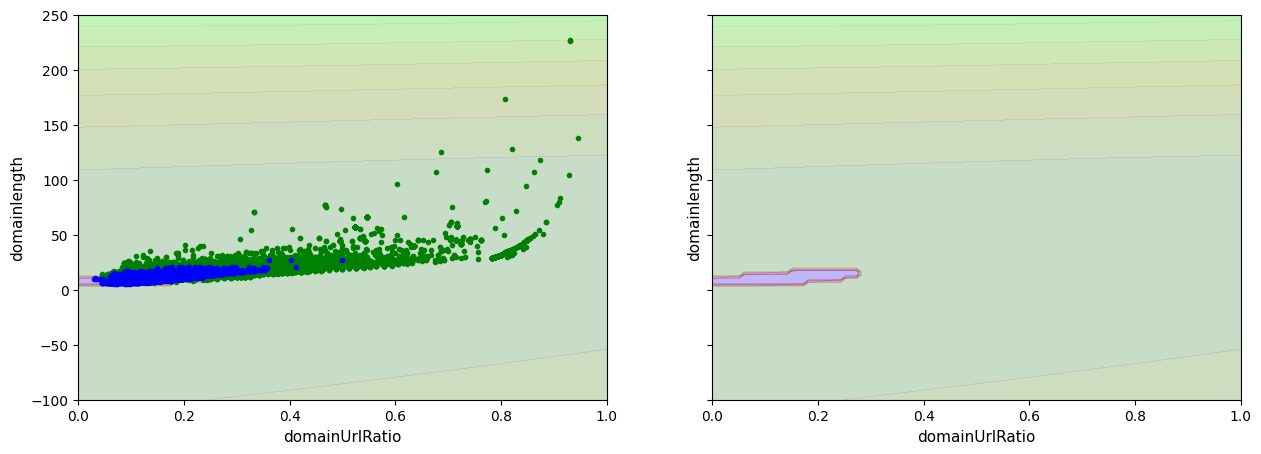

In [42]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Prediction with the reduced dataset**

In [43]:
y_pred = polynomial_svm_clf.predict(X_val_reduced)

In [44]:
print("F1 Score:", f1_score(y_pred, y_val_num))

F1 Score: 0.8574514038876889


### 6.2. Polynomial Kernel (II)

There is a simpler way to train an SVM algorithm using polynomial kernel using the **kernel** parameter of the sklearn function itself.

**Training the algorithm with a reduced dataset**

A higher value of coef0 will emphasize higher-degree polynomials in the decision function. In this case, setting coef0=10 gives more weight to the polynomial terms beyond just the linear interactions of the features.

In [ ]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=20)
svm_clf.fit(X_train_reduced, y_train_num)

SVC(C=20, coef0=10, kernel='poly')

**Representation of the decision boundary**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


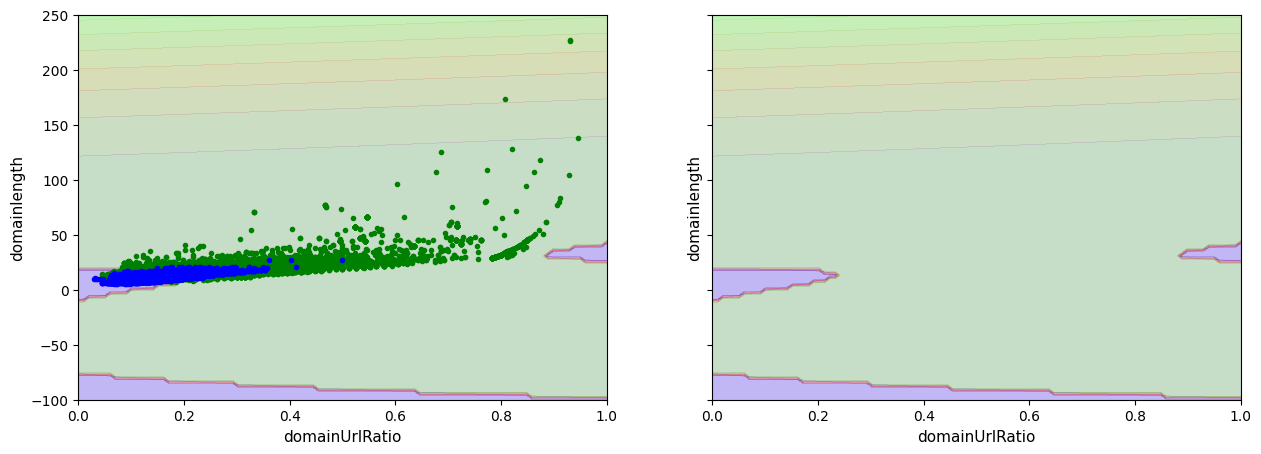

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Prediction with a small data set**

In [ ]:
y_pred = svm_clf.predict(X_val_reduced)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val_num))

F1 Score: 0.8249238062986793


**Prediction with the full dataset**

In [ ]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=40)
svm_clf.fit(X_train_prep, y_train_num)

SVC(C=40, coef0=10, kernel='poly')

In [ ]:
y_pred = svm_clf.predict(X_val_prep)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val_num))

F1 Score: 0.9715984147952443


### 6.2. Gaussian Kernel

**Training the algorithm with a reduced dataset**

The kernel="rbf" specifies the use of the Radial Basis Function (RBF) kernel. This is a popular kernel for non-linear classification problems. The RBF kernel allows the SVM to classify data that is not linearly separable by transforming the data into a higher-dimensional space.

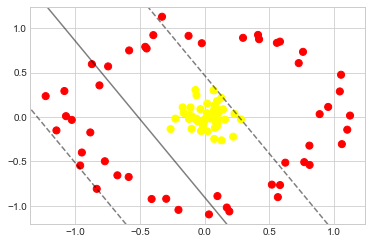

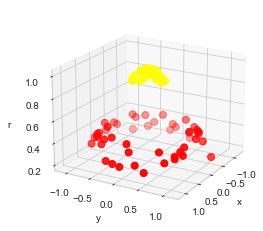

In [ ]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.5, C=1000))
        ])

rbf_kernel_svm_clf.fit(X_train_reduced, y_train_num)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.5))])

**Representation of the decision boundary**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


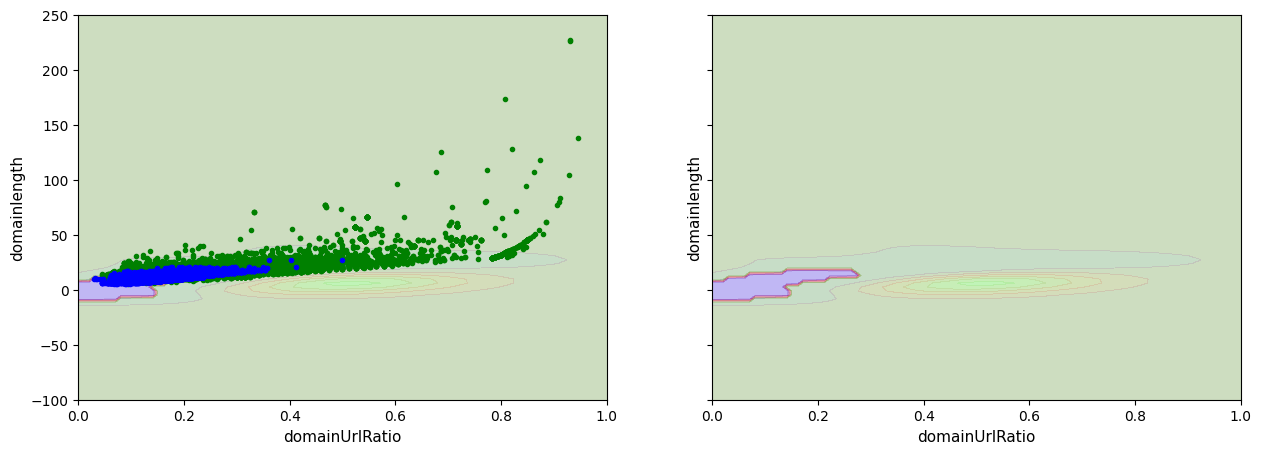

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(rbf_kernel_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(rbf_kernel_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Prediction with a small data set**

In [ ]:
y_pred = rbf_kernel_svm_clf.predict(X_val_reduced)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val_num))

F1 Score: 0.8617363344051447


**Prediction with a complete dataset**

In [ ]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.05, C=1000))
        ])

rbf_kernel_svm_clf.fit(X_train_prep, y_train_num)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.05))])

In [ ]:
y_pred = rbf_kernel_svm_clf.predict(X_val_prep)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val_num))

F1 Score: 0.9640522875816993
